In [60]:
import numpy as np
from matplotlib import pyplot as plt

# Read GENOME

In [63]:
genome = ''
with open('Salmonella_enterica.txt') as fp:
    print(fp.readline())
    for line in fp:
        genome = genome + line.replace('\n', '')

>gi|16758993|ref|NC_003198.1| Salmonella enterica subsp. enterica serovar Typhi str. CT18 chromosome, complete genome



In [67]:
print(genome[:1000])

AGAGATTACGTCTGGTTGCAAGAGATCATAACAGGGGAAATTGATTGAAAATAAATATATCGCCAGCAGCACATGAACAAGTTTCGGAATGTGATCAATTTAAAAATTTATTGACTTAGGCGGGCAGATACTTTAACCAATATAGGAATACAAGACAGACAAATAAAAATGACAGAGTACACAACATCCATGAACCGCATCAGCACCACCACCATTACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAGCCCGCACCTGAACAGTGCGGGCTTTTTTTTCGACCAGAGATCACGAGGTAACAACCATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAACGTTTTCTGCGTGTTGCCGATATTCTGGAAAGCAATTCCAGGCAAGGGCAGGTAGCGACCGTACTTTCCGCCCCCGCGAAAATTACCAACCATCTGGTGGCGATGATTGAAAAAACTATCGGCGGCCAGGATGCTTTGCCGAATATCAGCGATGCCGAACGTATTTTTTCTGACCTGCTCGCAGGACTTGCCAGCGCGCAGCCGGGATTCCCGCTTGCACGGTTGAAAATGGTTGTCGAACAAGAATTCGCTCAGATCAAACATGTTTTGCATGGTATCAGCCTGCTGGGTCAGTGCCCGGATAGCATCAACGCCGCGCTGATTTGCCGTGGCGAAAAAATGTCGATCGCGATTATGGCGGGACTCCTGGAGGCGCGTGGACATCGCGTCACGGTGATCGATCCGGTAGAAAAACTGCTGGCGGTGGGCCATTACCTTGAATCTACCGTCGATATCGCGGAATCGACTCGCCGTATCGCCGCCAGCCAGATCCCGGCCGATCACATGATCCTGATGGCGGGCTTTACTGCCGGTAATGAAAAGGGTGAACTGGTGGTGCTGGGCCGTAATGGTTCCGACTATTCCGCCGCCGTGCTGGCCGCCTGTTTACGCGCTGACT

# Plot Skew and find minimum

In [68]:
def MinimumSkew(genome):
    skew = [0]
    for c in genome:
        if c == 'G':
            skew.append(skew[-1] + 1)
        elif c == 'C':
            skew.append(skew[-1] - 1)
        else:
            skew.append(skew[-1])
    mins = np.where(np.array(skew) == min(skew))[0]
    return skew, mins

[3764856 3764858]


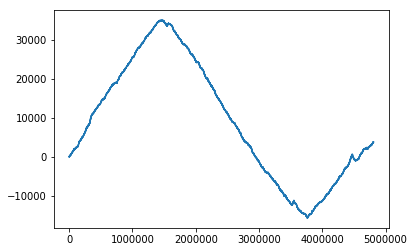

In [69]:
skew, mins = MinimumSkew(genome)
print(mins)
plt.plot(skew)
plt.show()

# Crop near the minimum - Locating ori
## (Where the DnaA box is more likely to be)

In [70]:
def get_portion(genome, windows_size):
    skew, mins = MinimumSkew(genome)
    min_ = int(min(mins) - windows_size/2)
    max_ = int(max(mins) + windows_size/2)
    return genome[min_: max_], skew[min_: max_]

In [76]:
text, skew_text = get_portion(genome, 1000)

In [77]:
text

'GCGTATTACACCACCGGTCACTACAGCATCTTTATAAAAGTGATGTGCAAATCAATTGACGCGCTTCAGCACGTACTTATCAACAAGATCCAAACAATTGATGAAATTCAGTCCACTGAGACACTGATCGTCTTGCAGAACCCGATCATGCGCACCATCAAGCCATGATCGGCTTTTTTAATCCCACATTTTTCCACAGGTAGATCCCAGCTCGTTCACAGAGTACAATGCAGCCTCTTTACCTGAGCGAGCGATCAATGGCAGACATTACTCTTATCAGCGGCAGCACCCTGGGCGGCGCCGAATACGTCGCGGAACATCTGGCGGAAAAGCTGGAAGCTGCCGGTTTTTCAACCGAAACGGTGCACGGTCCGTTATTAGAGGATCTGTCAACTTCCGGGATCTGGCTGATAATCAGCTCAACGCACGGCGCCGGAGACATTCCGGACAACCTGACCCCTTTCTATGAAGACCTTCAGACGCAGAAACCCGATCTTTCCGCGGTACGTTTCGGCGCAATTGGCATTGGCAGTCGAGAATACGACACGTTTTGCGGCGCGATTGAGAAAATAGAAGCGGAACTGAAAGGCGCTGGCGCAAAACAGGTTGGGGAAACACTGAAGATCAACATCCTTGAACATGAGATTCCGGAAGATCCAGCGGAGATTTGGCTCGGATCCTGGATTAATTTACTCAAATAAGTGTAAAGATCGTGCGATCTATTGTGGATAAATATGGTGAAAAGCTTGGATCAACCGGTAGTTATCCAAAGAATAACCTTTGTTCACTTTTTGAGTTGTGTATAAGTACCCGTTTTGATCCCAGCTTATACGGGCCACGATCACCGATCATTCACAGCTAGTGATCCTTTCCAACGCATTGATCTTTATTACAGGATCCGGGTTATCCACAGCCTGGTGCGATCCTAATAAGAGATCACAATAGAACAGATCTCTAAATAAAAAGATCTTCTTTTTAATAGCCCGGATCCCGGGGCTT

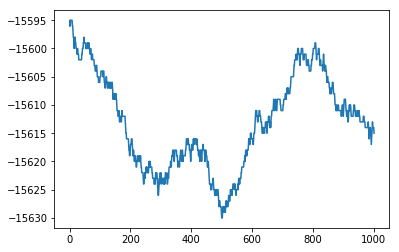

In [78]:
plt.plot(skew_text)

# Find DnaA box patterns

In [79]:
def HammingDistance(p, q):
    distance = 0
    for i, c1 in enumerate(p):
        if c1 != q[i]:
            distance = distance + 1
    return distance

def Neighbors(Pattern, d):
    if d == 0:
        return set([Pattern])
    if len(Pattern) == 1:
        return set(['A', 'C', 'G', 'T'])
    Neighborhood = set()
    Suffix = Pattern[1:]
    SuffixNeighbors = Neighbors(Suffix, d)
    for Text in SuffixNeighbors:
        if HammingDistance(Suffix, Text) < d:
            for x in 'ACGT':
                Neighborhood.add(x + Text)
        else:
            Neighborhood.add(Pattern[0] + Text)
    return Neighborhood

def ReverseComplement(Pattern):
    reversed = ''
    revDict = {
        "A": "T",
        "T": "A",
        "C": "G",
        "G": "C"
    }
    for c in Pattern[::-1]:
        reversed = reversed + revDict[c]
    return reversed

def FrequentWordsWithMismatchesAndReverseComplements(Text, k, d):
    FrequentPatterns = set()
    Neighborhoods = []
    # Get neighbours of all patterns
    for i in range(len(Text) - k + 1):
        Neighborhoods = Neighborhoods + list(Neighbors(Text[i: i+k], d))
    patternDict = {}
    maxCount = 0
    for i, Pattern in enumerate(Neighborhoods):
        if Pattern not in patternDict:
            patternDict[Pattern] = 0
        patternDict[Pattern] = patternDict[Pattern] + 1
        if patternDict[Pattern] > maxCount:
            maxCount = patternDict[Pattern]
    for i, Pattern in enumerate(Neighborhoods):
        Pattern = ReverseComplement(Pattern)
        if Pattern not in patternDict:
            patternDict[Pattern] = 0
        patternDict[Pattern] = patternDict[Pattern] + 1
        if patternDict[Pattern] > maxCount:
            maxCount = patternDict[Pattern]
    for k, v in patternDict.items():
        if v == maxCount:
            FrequentPatterns.add(k)
    return FrequentPatterns, maxCount

In [80]:
FrequentWordsWithMismatchesAndReverseComplements(text, 9, 1)

({'TGTGGATAA', 'TTATCCACA'}, 6)

In [81]:
FrequentWordsWithMismatchesAndReverseComplements(text, 9, 2)

({'ATAAAAAAG', 'CGGATCATC', 'CTTTTTTAT', 'GATGATCCG'}, 17)

# TTATC[CA]A[CA]A